In [1]:
import sys
sys.path.append('/home/jupyter/notebooks/src')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from utils.data_generator import Data_Generator
from utils.vocabulary import Vocabulary
# from models.dense_conv_variant import Model
# from models.siamese_dense_maxpool import Model
from models.siamese_dense_conv import Model
import keras
import numpy as np

Using TensorFlow backend.


In [2]:
model_file = '/home/jupyter/data/model_snapshots/run106/dense-conv.30-0.39-0.83.hdf5'
vocab_file = '/home/jupyter/data/model_snapshots/run107/vocab.pickle'
glove_file = '/home/jupyter/data/vocab/glove.42B.300d.txt'

In [3]:
vocab = Vocabulary()
vocab.load(vocab_file)

In [4]:
arch = Model(vocab)

/home/jupyter/notebooks/src/models/dense_conv_variant.py:46: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=5, strides=1, filters=64, activation="relu", padding="valid")`
  subsample_length=1))
/home/jupyter/notebooks/src/models/dense_conv_variant.py:53: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=5, strides=1, filters=64, activation="relu", padding="valid")`
  subsample_length=1))
/home/jupyter/notebooks/src/models/dense_conv_variant.py:69: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=5, strides=1, filters=64, activation="relu", padding="valid")`
  subsample_length=1))
/home/jupyter/notebooks/src/models/dense_conv_variant.py:76: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=5, strides=1, filters=64, activation="relu", padding="valid")`
  subsample_length=1))
/home/jupyter/notebooks/src/models/dense_conv_variant.py:96: UserWarning: The `Merge` layer is d

In [5]:
arch.load_weights(model_file)

In [6]:
data_gen = Data_Generator(vocab,1,None)

In [7]:
question_pair = ["What are the most interesting foods you have eaten in any country?","What is the most delicious dish you've ever eaten and why?"]
# question_pair = ["What are the best ways to earn money from home?","What is best way to make money online?"]
# question_pair = ["What African country is the most successful today?","What are the most prosperous African nations?"]
# question_pair = ["Why does China block sanctions at the UN against the Jaish-e-Mohammad (JeM) chief, Masood Azhar?","Why does China support Masood Azhar?"]
# question_pair = ["How do I register my domain site email?","How do you register a .an domain?"]
# question_pair = ["What is the funniest joke you know?","What is the funniest joke of all time?"]
q1_seq = data_gen.text_to_sequence(question_pair[0])
q2_seq = data_gen.text_to_sequence(question_pair[1])

print(q1_seq)
print(q2_seq)

arch.predict(q1_seq,q2_seq)

[[   0    0    0    3   12    2   51  367 1580   16   28 4006    9   59
   209]]
[[   0    0    0    0    3    4    2   51 5675 3619  426   88 4006   13
    17]]


array([[0.5468043]], dtype=float32)

## Get prediction probs for Validation data


In [8]:
val_file = '/home/jupyter/data/valid.csv'

data_gen.bulk_load(val_file)

In [9]:
eval_batches = data_gen.gen_evaluation_data()
print('Number of batches',len(eval_batches))
prediction_probs = []
true_labels = []
for index,batch in enumerate(eval_batches):
    prediction = arch.predict(batch[0],batch[1])
    prediction_probs.append(prediction)
    true_labels.append(batch[2])
    
    if index % 100 == 0:
        print('Done :',index)

prediction_probs = np.stack(prediction_probs,axis=0).reshape((-1,1))
true_labels = np.stack(true_labels,axis=0).reshape((-1,1))

print(prediction_probs.shape,true_labels.shape)

Number of batches 2274
Done : 0
Done : 100
Done : 200
Done : 300
Done : 400
Done : 500
Done : 600
Done : 700
Done : 800
Done : 900
Done : 1000
Done : 1100
Done : 1200
Done : 1300
Done : 1400
Done : 1500
Done : 1600
Done : 1700
Done : 1800
Done : 1900
Done : 2000
Done : 2100
Done : 2200
(72768, 1) (72768, 1)


In [10]:
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,f1_score,accuracy_score

In [11]:
area = roc_auc_score(true_labels, prediction_probs)

In [12]:
fpr,tpr,thresholds = roc_curve(true_labels,prediction_probs)

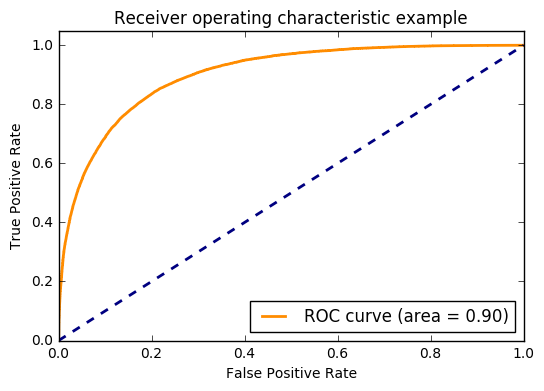

In [13]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [14]:
for threshold in np.arange(0.1,0.9,0.05):
    print('Threshold:',threshold)
    predicted_classes = (prediction_probs[:,0] > threshold).astype(np.int)

    tn, fp, fn, tp = confusion_matrix(true_labels,predicted_classes).ravel()

    f1 = f1_score(true_labels,predicted_classes)
    acc = accuracy_score(true_labels,predicted_classes)
    
    print('F1 score:',f1)
    print('Accuracy:',acc)
    print('---------------')

Threshold: 0.1
F1 score: 0.7374674431535512
Accuracy: 0.7534355760773966
---------------
Threshold: 0.15000000000000002
F1 score: 0.7530107493762898
Accuracy: 0.7796009234828496
---------------
Threshold: 0.20000000000000004
F1 score: 0.7624991956759538
Accuracy: 0.7971086191732629
---------------
Threshold: 0.25000000000000006
F1 score: 0.7680669456066946
Accuracy: 0.8095591468777484
---------------
Threshold: 0.30000000000000004
F1 score: 0.767859934344224
Accuracy: 0.8163341029023746
---------------
Threshold: 0.3500000000000001
F1 score: 0.7656463318243873
Accuracy: 0.8207178979771328
---------------
Threshold: 0.40000000000000013
F1 score: 0.7624006374029536
Accuracy: 0.8237824318381706
---------------
Threshold: 0.45000000000000007
F1 score: 0.7544781968686077
Accuracy: 0.8235075857519789
---------------
Threshold: 0.5000000000000001
F1 score: 0.7447581441263574
Accuracy: 0.8223394898856641
---------------
Threshold: 0.5500000000000002
F1 score: 0.7300083702509034
Accuracy: 0.818